In [1]:
import pyspark
from pyspark import SparkContext
import pandas as pd
import numpy as np

In [2]:
sc = SparkContext.getOrCreate()

In [3]:
df = pd.read_csv('Aggregation.txt', sep = '\t', header=None)

<AxesSubplot:xlabel='0', ylabel='1'>

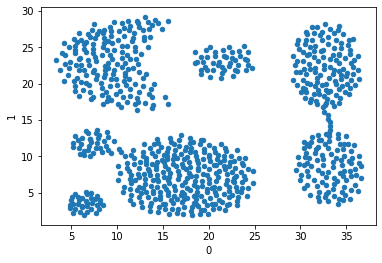

In [4]:
df.plot(x=0,y=1,kind='scatter')

In [5]:
x = df[0].to_list()
y = df[1].to_list()
points = np.array(list(zip(x,y)))

In [6]:
centroids = points[np.random.choice(points.shape[0], 3, replace=False), :]

In [7]:
centroids

array([[16.95, 10.35],
       [20.05,  6.35],
       [35.7 , 22.3 ]])

In [8]:
def kMap(x, mu):
    distances = np.zeros((mu.shape[0]))
    for i in range(mu.shape[0]):
        distances[i] = np.linalg.norm(x-mu[i])
    return (np.argmin(distances), (x, 1))

In [9]:
points_dist = sc.parallelize(points)

In [10]:
res = points_dist.map(lambda x: (kMap(x, centroids)))

In [12]:
def kReduce(x):
    x = list(x)
    return [sum(i) for i in zip(*x)]

In [14]:
res2 = res.groupByKey().mapValues(lambda x: kReduce(x))

In [15]:
res2.collect()

[(0, [array([4464.55, 6129.05]), 390]),
 (1, [array([4647.9, 1196.7]), 201]),
 (2, [array([6306.2, 3841.6]), 197])]

In [67]:
def means(x):
    x = list(x)
    return x[0][0] / x[0][1]

In [103]:
def getCentroidsFromTup(x):
    return np.array([i[1] for i in x])

In [76]:
res3 = res2.groupByKey().mapValues(lambda x: means(x))

In [81]:
prov = res3.collect()

In [112]:
def KMeans(x, centroids):
    while 1:
        step0 = x.map(lambda x: kMap(x, centroids))
        step1 = step0.groupByKey().mapValues(lambda x: kReduce(x))
        new_centroids = getCentroidsFromTup(step1.groupByKey().mapValues(lambda x: means(x)).collect())
        if np.all(new_centroids != centroids):
            print('Update')
            centroids = new_centroids
        else:
            return centroids, step0
    

In [113]:
KMeans(points_dist,centroids)

Update
Update
Update
Update
Update
Update
Update
Update
Update


array([[10.99878641, 22.72645631],
       [15.44821429,  7.18958333],
       [32.36707317, 16.54471545]])